In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

labels = {'NORMAL': 0, 'PNEUMONIA': 1}
PATH = 'chest_xray'
IMG_SIZE = 80

In [2]:
def prepareData(dir_):
    X = []
    y = []
    
    for category in ['NORMAL', 'PNEUMONIA']:
        loc = os.path.join(PATH, dir_, category)
        for name in os.listdir(loc):
            img = cv2.imread(os.path.join(loc, name), 0)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(labels[category])
    return X, y

In [ ]:
X, y = prepareData('train')
file = open('X_train.pickle', 'wb')
pickle.dump([X, y], file)
file.close()

In [3]:
with open('X_train.pickle', 'rb') as file:
    X, y = pickle.load(file)

# Feature Scaling
X = np.array(X) / 255.0

In [4]:
# Shuffling the Dataset
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=4)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 78, 78, 64)        640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)       

In [12]:
history = model.fit(X, np.array(y), batch_size=32, epochs=10, validation_split=0.1)

Train on 4694 samples, validate on 522 samples
Epoch 1/10
4694/4694 [==============================] - 61s 13ms/sample - loss: 0.4504 - accuracy: 0.7940 - val_loss: 0.3066 - val_accuracy: 0.9061
Epoch 2/10
4694/4694 [==============================] - 55s 12ms/sample - loss: 0.2181 - accuracy: 0.9118 - val_loss: 0.1278 - val_accuracy: 0.9540
Epoch 3/10
4694/4694 [==============================] - 54s 12ms/sample - loss: 0.1775 - accuracy: 0.9320 - val_loss: 0.1275 - val_accuracy: 0.9483
Epoch 4/10
4694/4694 [==============================] - 62s 13ms/sample - loss: 0.1503 - accuracy: 0.9480 - val_loss: 0.1201 - val_accuracy: 0.9540
Epoch 5/10
4694/4694 [==============================] - 56s 12ms/sample - loss: 0.1317 - accuracy: 0.9546 - val_loss: 0.1088 - val_accuracy: 0.9559
Epoch 6/10
4694/4694 [==============================] - 55s 12ms/sample - loss: 0.1212 - accuracy: 0.9546 - val_loss: 0.0858 - val_accuracy: 0.9598
Epoch 7/10
4694/4694 [==============================] - 54s 12ms/

In [13]:
# Saving the weights of the model
model.save_weights('model.h5')

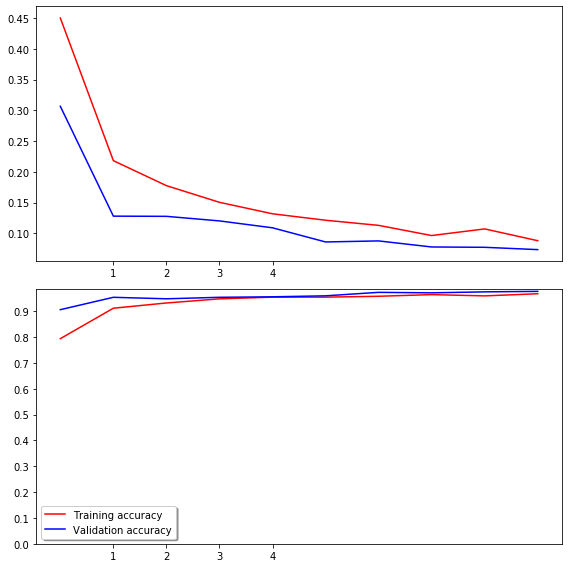

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(history.history['loss'], c='r', label='Training Loss')
ax1.plot(history.history['val_loss'], c='b', label='Validation Loss')
ax1.set_xticks(np.arange(1, 5, 1))

ax2.plot(history.history['accuracy'], color='r', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 5, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [38]:
# Preparing data for testing
X, y = prepareData('test')
file = open('X_test.pickle', 'wb')
pickle.dump([X, y], file)
file.close()

In [46]:
with open('X_test.pickle', 'rb') as file:
    X_test, y_test = pickle.load(file)

# Feature Scaling
X_test = np.array(X_test) / 255.0
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [47]:
# Predicting from the trained model
predictions = model.predict(X_test)

In [52]:
y_pred = [list(row).index(max(list(row))) for row in predictions]
print('Test Accuracy:- ', 100.0*(1 - sum(abs(np.array(y_pred) - np.array(y_test))) / len(y_test)))

Test Accuracy:-  79.8076923076923


In [53]:
import pandas as pd

save = pd.DataFrame()
save['Pneumonia'] = np.array(y_pred)
save.to_csv('predictions.csv', index=False)